# Data Preprocessing

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import sys
from pydub import AudioSegment
import scipy as sp
from scipy.io import wavfile
from scipy import signal
from scipy.fftpack import fft,irfft,rfft,ifft,fftfreq,fftshift
import seaborn as sns
import os
import math
import pickle
import csv
from heapq import nlargest

import pandas as pd
import sklearn as sk
from sklearn import svm
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix 

sns.set()

In [2]:
def plot_wav(rate, data):    
    Time=np.linspace(0, float(len(data))/rate, num=len(data))

    n_sample = len(data)
    sample_space = 1.0/rate

    xf = np.linspace(0.0, 1.0/(2.0*sample_space),n_sample//2)
    
    fig, [ax1,ax2,ax3] = plt.subplots(nrows=3, ncols=1,figsize=(18,18))
    ax1.set_title('Raw Wave')
    ax1.plot(Time,data,"b")
    ax1.set_xlabel("Time(s)")
    ax1.set_ylabel("Amplitude")

    ax2.plot(xf, 2.0/n_sample * np.abs(np.fft.fft(data)[0:n_sample//2]),"b")
    ax2.set_title('Spectrum')
    ax2.set_ylabel('FFT magnitude')
    ax2.set_xlabel('Frequency')

    ax3.set_title('Spectrogram')
    ax3.specgram(data, Fs=rate,cmap='Blues')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Frequency')
    ax3.grid(False)

    plt.show()

In [3]:
# keep only 1khz to 10khez frequence for the spectrogram
def select_freq(t,f,S):
    index=[i for i,freq in enumerate(f) if freq>1000 and freq<10000]
    freq=f[index]
    Spec=S[index,:]
    return t,freq,Spec

In [4]:
#filter the wav file by freqence, keep only the frequence from 1khz to 10khz 
def select_by_freq(rate, data):
    f=np.fft.fft(data)
    n_sample = len(data)
    sample_freq =fftfreq(n_sample, d=1.0/rate)
    f[np.where(sample_freq>10000)]=0
    f[np.where((sample_freq<1000) & (sample_freq>-1000))]=0
    f[np.where(sample_freq<-10000)]=0
    sig=np.real(np.fft.ifft(f))
    return rate, sig

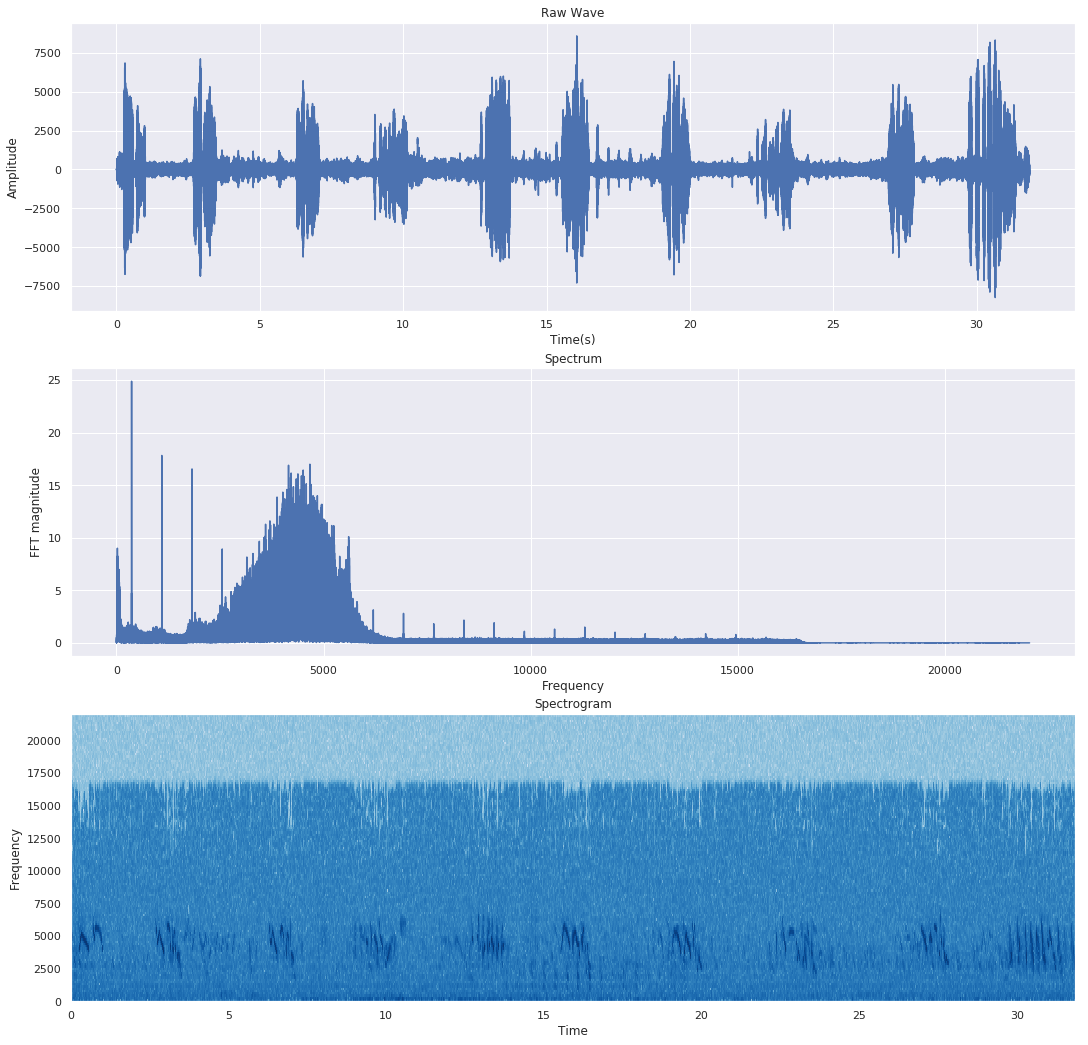

In [181]:
#example:
rate,test=wavfile.read("data_2/birds_wav/Rose-Crested-Blue-Pipit-191415.wav",'r')
if test.ndim==2:
    test=test[:,0]

plot_wav(rate,test)

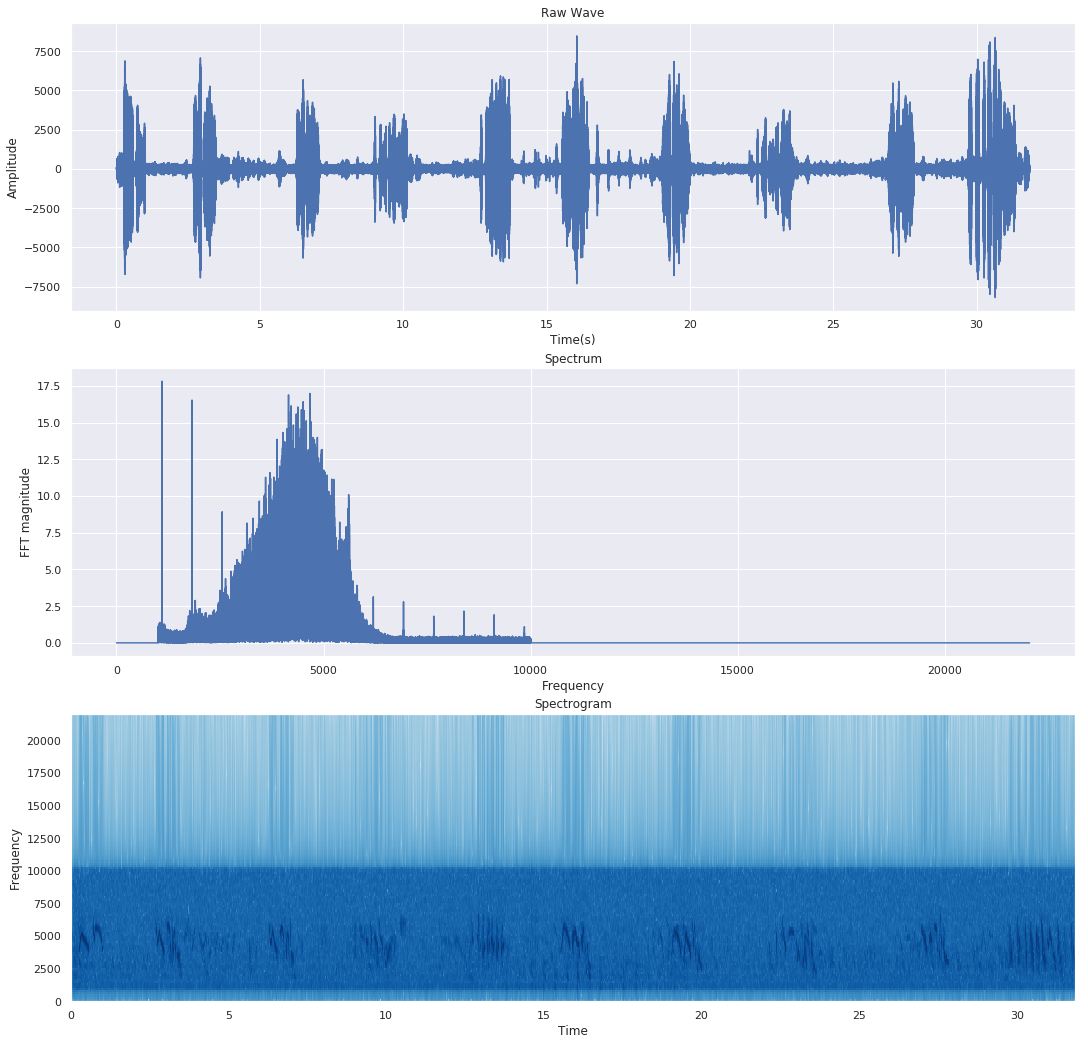

In [182]:
rate,test=select_by_freq(rate,test)
plot_wav(rate,test)

In [184]:
#apply the power threshold method 
def select_by_PTM(rate,data):
    '''
    get a path of a wavfile and use power threshold method to get new training records
    '''
    N=int(0.01*len(data))
    mean_energy = np.mean(nlargest(N,np.abs(data)))
    data2 = np.array([i for i in data if np.abs(i) > 0.25 * mean_energy])
    
    return rate, data2

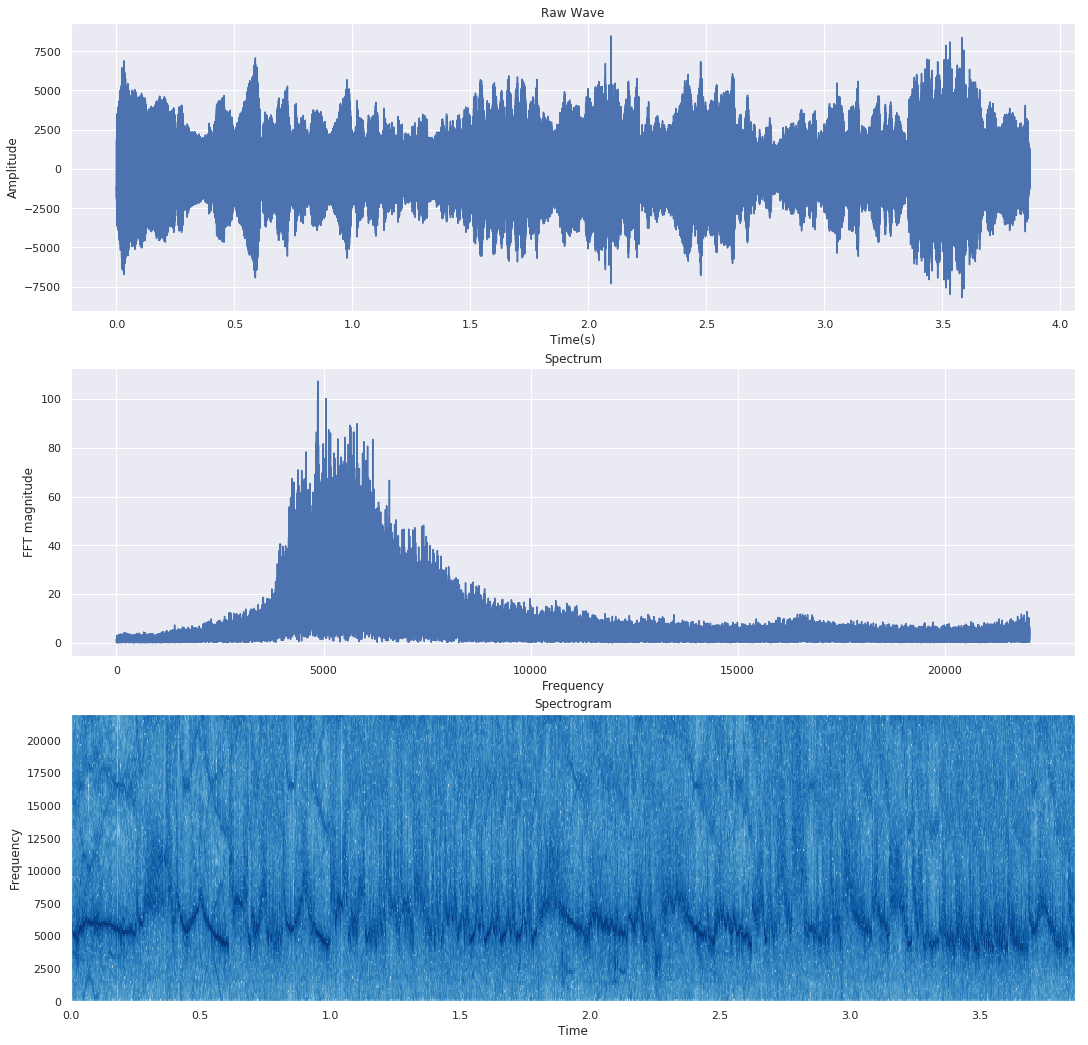

In [185]:
rate,test=select_by_PTM(rate,test)
plot_wav(rate,test)

In [186]:
#Create sequences of 100-frames:
def Create_Seq(Spec):
    l_seq=[]
    nb_seq=len(Spec[0,:])//100
    for i in range(nb_seq):
        l_seq.append(Spec[:,i*100:(i+1)*100])
    return l_seq

In [187]:
#calculte fmode for a sequence:
def fmode(freq,Spec_seq):
    fm=[]
    for i in range(len(Spec_seq[0,:])):
        fm=fm + freq[np.where(Spec_seq[:,i]==max(Spec_seq[:,i]))].tolist()
    return fm

In [188]:
#calculate delta_fmode
def d_fmode(f_mode):
    fm=[]
    for i in range(len(f_mode) - 1):
        fm.append(f_mode[i + 1] - f_mode[i])
    return fm

In [189]:
# choose 5th 50th 95th percentiles of fmode and 50th 75th 95th of delta_fmode 
def features_chosen(freq,Spec_seq):
    f_mode=fmode(freq,Spec_seq)
    delta_fmode=d_fmode(f_mode)
    f_mode.sort()
    delta_fmode.sort()
    features=[f_mode[4],f_mode[49],f_mode[94],delta_fmode[49],delta_fmode[74],delta_fmode[94]]
    return features

In [60]:
#build the data set:
def data_set(name):
    #take all the samples of name_bird
    name_birds=[]
    for name2 in os.listdir('data_2/birds_wav/'):
        if '-'.join(name2.split('-')[:-1]) == name:
            name_birds.append(name2)
    data_total=[]
    for i in range(len(name_birds)):
        rate,data =wavfile.read('data_2/birds_wav/' + name_birds[i],'r')#power threshold
        if data.ndim==2:
            data=data[:,0]
        rate,data=select_by_freq(rate,data)
        print('freq',name_birds[i])
        rate,data=select_by_PTM(rate,data)
        print('PTM',name_birds[i])
        if i==0:
            data_total=data.copy()
        else:
            data_total=np.concatenate((data_total,data))
        if (i%5==0):
            print(i)
    return data_total

In [190]:
#take all the birds_name
birds_name = set()

for file in os.listdir('data_2/ALL_BIRDS/'):
    birds_name.add('-'.join(file.split('-')[:-1]))
birds_name=list(birds_name) 
print(birds_name)

['Eastern-Corn-Skeet', 'Vermillion-Trillian', 'Queenscoat', 'Lesser-Birchbeere', 'Canadian-Cootamum', 'Scrawny-Jay', 'Pinkfinch', 'Rose-Crested-Blue-Pipit', 'Blue-collared-Zipper', 'Broad-winged-Jojo', 'Qax', 'Orange-Pine-Plover', 'Carries-Champagne-Pipit', 'Bombadil', 'Green-Tipped-Scarlet-Pipit', 'Darkwing-Sparrow', 'Ordinary-Snape', 'Purple-Tooting-Tout', 'Bent-Beak-Riffraff']


In [101]:
#get the features from all the wav files
dataset=[]
for name in birds_name:
    data=data_set(name)
    file1 = open(name + '.pckl', 'wb')
    pickle.dump(data, file1)
    file1.close()
    dataset.append(data)

freq Eastern-Corn-Skeet-1375.wav
PTM Eastern-Corn-Skeet-1375.wav
0
freq Eastern-Corn-Skeet-111142.wav
PTM Eastern-Corn-Skeet-111142.wav
freq Eastern-Corn-Skeet-191964.wav
PTM Eastern-Corn-Skeet-191964.wav
freq Eastern-Corn-Skeet-111143.wav
PTM Eastern-Corn-Skeet-111143.wav
freq Eastern-Corn-Skeet-323217.wav
PTM Eastern-Corn-Skeet-323217.wav
freq Eastern-Corn-Skeet-321819.wav
PTM Eastern-Corn-Skeet-321819.wav
5
freq Eastern-Corn-Skeet-378993.wav
PTM Eastern-Corn-Skeet-378993.wav
freq Eastern-Corn-Skeet-14858.wav
PTM Eastern-Corn-Skeet-14858.wav
freq Eastern-Corn-Skeet-149935.wav
PTM Eastern-Corn-Skeet-149935.wav
freq Eastern-Corn-Skeet-1376.wav
PTM Eastern-Corn-Skeet-1376.wav
freq Eastern-Corn-Skeet-111141.wav
PTM Eastern-Corn-Skeet-111141.wav
10
freq Eastern-Corn-Skeet-150242.wav
PTM Eastern-Corn-Skeet-150242.wav
freq Eastern-Corn-Skeet-124070.wav
PTM Eastern-Corn-Skeet-124070.wav
freq Eastern-Corn-Skeet-388696.wav
PTM Eastern-Corn-Skeet-388696.wav
freq Eastern-Corn-Skeet-184376.wav
PT

PTM Vermillion-Trillian-301392.wav
30
freq Vermillion-Trillian-239357.wav
PTM Vermillion-Trillian-239357.wav
freq Vermillion-Trillian-42461.wav
PTM Vermillion-Trillian-42461.wav
freq Vermillion-Trillian-210869.wav
PTM Vermillion-Trillian-210869.wav
freq Vermillion-Trillian-210868.wav
PTM Vermillion-Trillian-210868.wav
freq Vermillion-Trillian-179669.wav
PTM Vermillion-Trillian-179669.wav
35
freq Vermillion-Trillian-309652.wav
PTM Vermillion-Trillian-309652.wav
freq Vermillion-Trillian-169066.wav
PTM Vermillion-Trillian-169066.wav
freq Vermillion-Trillian-150395.wav
PTM Vermillion-Trillian-150395.wav
freq Vermillion-Trillian-210872.wav
PTM Vermillion-Trillian-210872.wav
freq Vermillion-Trillian-366477.wav
PTM Vermillion-Trillian-366477.wav
40
freq Vermillion-Trillian-150394.wav
PTM Vermillion-Trillian-150394.wav
freq Vermillion-Trillian-236287.wav
PTM Vermillion-Trillian-236287.wav
freq Vermillion-Trillian-101242.wav
PTM Vermillion-Trillian-101242.wav
freq Vermillion-Trillian-141672.wav

PTM Queenscoat-78170.wav
freq Queenscoat-292438.wav
PTM Queenscoat-292438.wav
freq Queenscoat-190268.wav
PTM Queenscoat-190268.wav
freq Queenscoat-265852.wav
PTM Queenscoat-265852.wav
85
freq Queenscoat-124685.wav
PTM Queenscoat-124685.wav
freq Queenscoat-40217.wav
PTM Queenscoat-40217.wav
freq Queenscoat-166689.wav
PTM Queenscoat-166689.wav
freq Queenscoat-98668.wav
PTM Queenscoat-98668.wav
freq Queenscoat-124684.wav
PTM Queenscoat-124684.wav
90
freq Queenscoat-235137.wav
PTM Queenscoat-235137.wav
freq Queenscoat-25538.wav
PTM Queenscoat-25538.wav
freq Queenscoat-346440.wav
PTM Queenscoat-346440.wav
freq Queenscoat-78167.wav
PTM Queenscoat-78167.wav
freq Queenscoat-127576.wav
PTM Queenscoat-127576.wav
95
freq Queenscoat-185672.wav
PTM Queenscoat-185672.wav
freq Queenscoat-215352.wav
PTM Queenscoat-215352.wav
freq Queenscoat-330677.wav
PTM Queenscoat-330677.wav
freq Queenscoat-263213.wav
PTM Queenscoat-263213.wav
freq Queenscoat-75084.wav
PTM Queenscoat-75084.wav
100
freq Queenscoat-28

PTM Queenscoat-282864.wav
freq Queenscoat-320584.wav
PTM Queenscoat-320584.wav
freq Queenscoat-300481.wav
PTM Queenscoat-300481.wav
freq Queenscoat-388636.wav
PTM Queenscoat-388636.wav
freq Queenscoat-302241.wav
PTM Queenscoat-302241.wav
240
freq Lesser-Birchbeere-76499.wav
PTM Lesser-Birchbeere-76499.wav
0
freq Lesser-Birchbeere-138711.wav
PTM Lesser-Birchbeere-138711.wav
freq Lesser-Birchbeere-302409.wav
PTM Lesser-Birchbeere-302409.wav
freq Lesser-Birchbeere-169204.wav
PTM Lesser-Birchbeere-169204.wav
freq Lesser-Birchbeere-197938.wav
PTM Lesser-Birchbeere-197938.wav
freq Lesser-Birchbeere-377860.wav
PTM Lesser-Birchbeere-377860.wav
5
freq Lesser-Birchbeere-220910.wav
PTM Lesser-Birchbeere-220910.wav
freq Lesser-Birchbeere-169198.wav
PTM Lesser-Birchbeere-169198.wav
freq Lesser-Birchbeere-220905.wav
PTM Lesser-Birchbeere-220905.wav
freq Lesser-Birchbeere-377861.wav
PTM Lesser-Birchbeere-377861.wav
freq Lesser-Birchbeere-312747.wav
PTM Lesser-Birchbeere-312747.wav
10
freq Lesser-Birc

PTM Lesser-Birchbeere-233794.wav
freq Lesser-Birchbeere-153027.wav
PTM Lesser-Birchbeere-153027.wav
freq Lesser-Birchbeere-187276.wav
PTM Lesser-Birchbeere-187276.wav
120
freq Lesser-Birchbeere-95722.wav
PTM Lesser-Birchbeere-95722.wav
freq Lesser-Birchbeere-293867.wav
PTM Lesser-Birchbeere-293867.wav
freq Lesser-Birchbeere-98204.wav
PTM Lesser-Birchbeere-98204.wav
freq Lesser-Birchbeere-95720.wav
PTM Lesser-Birchbeere-95720.wav
freq Lesser-Birchbeere-281905.wav
PTM Lesser-Birchbeere-281905.wav
125
freq Lesser-Birchbeere-234990.wav
PTM Lesser-Birchbeere-234990.wav
freq Lesser-Birchbeere-257563.wav
PTM Lesser-Birchbeere-257563.wav
freq Lesser-Birchbeere-56420.wav
PTM Lesser-Birchbeere-56420.wav
freq Lesser-Birchbeere-109316.wav
PTM Lesser-Birchbeere-109316.wav
freq Lesser-Birchbeere-352547.wav
PTM Lesser-Birchbeere-352547.wav
130
freq Lesser-Birchbeere-95725.wav
PTM Lesser-Birchbeere-95725.wav
freq Lesser-Birchbeere-95719.wav
PTM Lesser-Birchbeere-95719.wav
freq Lesser-Birchbeere-320102

PTM Scrawny-Jay-32401.wav
freq Scrawny-Jay-45058.wav
PTM Scrawny-Jay-45058.wav
freq Scrawny-Jay-364750.wav
PTM Scrawny-Jay-364750.wav
freq Scrawny-Jay-32400.wav
PTM Scrawny-Jay-32400.wav
freq Scrawny-Jay-195856.wav
PTM Scrawny-Jay-195856.wav
15
freq Scrawny-Jay-51404.wav
PTM Scrawny-Jay-51404.wav
freq Scrawny-Jay-13555.wav
PTM Scrawny-Jay-13555.wav
freq Scrawny-Jay-10289.wav
PTM Scrawny-Jay-10289.wav
freq Scrawny-Jay-14575.wav
PTM Scrawny-Jay-14575.wav
freq Scrawny-Jay-51405.wav
PTM Scrawny-Jay-51405.wav
20
freq Scrawny-Jay-2622.wav
PTM Scrawny-Jay-2622.wav
freq Scrawny-Jay-290417.wav
PTM Scrawny-Jay-290417.wav
freq Scrawny-Jay-13556.wav
PTM Scrawny-Jay-13556.wav
freq Scrawny-Jay-394329.wav
PTM Scrawny-Jay-394329.wav
freq Scrawny-Jay-143351.wav
PTM Scrawny-Jay-143351.wav
25
freq Scrawny-Jay-13557.wav
PTM Scrawny-Jay-13557.wav
freq Scrawny-Jay-4627.wav
PTM Scrawny-Jay-4627.wav
freq Scrawny-Jay-301354.wav
PTM Scrawny-Jay-301354.wav
freq Scrawny-Jay-14511.wav
PTM Scrawny-Jay-14511.wav
fre

PTM Rose-Crested-Blue-Pipit-353709.wav
freq Rose-Crested-Blue-Pipit-345802.wav
PTM Rose-Crested-Blue-Pipit-345802.wav
freq Rose-Crested-Blue-Pipit-291662.wav
PTM Rose-Crested-Blue-Pipit-291662.wav
freq Rose-Crested-Blue-Pipit-41282.wav
PTM Rose-Crested-Blue-Pipit-41282.wav
freq Rose-Crested-Blue-Pipit-313073.wav
PTM Rose-Crested-Blue-Pipit-313073.wav
5
freq Rose-Crested-Blue-Pipit-345553.wav
PTM Rose-Crested-Blue-Pipit-345553.wav
freq Rose-Crested-Blue-Pipit-387404.wav
PTM Rose-Crested-Blue-Pipit-387404.wav
freq Rose-Crested-Blue-Pipit-387405.wav
PTM Rose-Crested-Blue-Pipit-387405.wav
freq Rose-Crested-Blue-Pipit-345552.wav
PTM Rose-Crested-Blue-Pipit-345552.wav
freq Rose-Crested-Blue-Pipit-41283.wav
PTM Rose-Crested-Blue-Pipit-41283.wav
10
freq Rose-Crested-Blue-Pipit-106772.wav
PTM Rose-Crested-Blue-Pipit-106772.wav
freq Rose-Crested-Blue-Pipit-191418.wav
PTM Rose-Crested-Blue-Pipit-191418.wav
freq Rose-Crested-Blue-Pipit-312965.wav
PTM Rose-Crested-Blue-Pipit-312965.wav
freq Rose-Cr

freq Rose-Crested-Blue-Pipit-277952.wav
PTM Rose-Crested-Blue-Pipit-277952.wav
105
freq Rose-Crested-Blue-Pipit-118322.wav
PTM Rose-Crested-Blue-Pipit-118322.wav
freq Rose-Crested-Blue-Pipit-164203.wav
PTM Rose-Crested-Blue-Pipit-164203.wav
freq Rose-Crested-Blue-Pipit-139528.wav
PTM Rose-Crested-Blue-Pipit-139528.wav
freq Rose-Crested-Blue-Pipit-299736.wav
PTM Rose-Crested-Blue-Pipit-299736.wav
freq Rose-Crested-Blue-Pipit-125878.wav
PTM Rose-Crested-Blue-Pipit-125878.wav
110
freq Rose-Crested-Blue-Pipit-401720.wav
PTM Rose-Crested-Blue-Pipit-401720.wav
freq Rose-Crested-Blue-Pipit-163385.wav
PTM Rose-Crested-Blue-Pipit-163385.wav
freq Rose-Crested-Blue-Pipit-91352.wav
PTM Rose-Crested-Blue-Pipit-91352.wav
freq Rose-Crested-Blue-Pipit-70543.wav
PTM Rose-Crested-Blue-Pipit-70543.wav
freq Rose-Crested-Blue-Pipit-313778.wav
PTM Rose-Crested-Blue-Pipit-313778.wav
115
freq Rose-Crested-Blue-Pipit-191476.wav
PTM Rose-Crested-Blue-Pipit-191476.wav
freq Rose-Crested-Blue-Pipit-125879.wav
PTM 

freq Blue-collared-Zipper-116386.wav
PTM Blue-collared-Zipper-116386.wav
freq Blue-collared-Zipper-113765.wav
PTM Blue-collared-Zipper-113765.wav
25
freq Blue-collared-Zipper-74792.wav
PTM Blue-collared-Zipper-74792.wav
freq Blue-collared-Zipper-3371.wav
PTM Blue-collared-Zipper-3371.wav
freq Blue-collared-Zipper-230058.wav
PTM Blue-collared-Zipper-230058.wav
freq Blue-collared-Zipper-176506.wav
PTM Blue-collared-Zipper-176506.wav
freq Blue-collared-Zipper-260444.wav
PTM Blue-collared-Zipper-260444.wav
30
freq Blue-collared-Zipper-230059.wav
PTM Blue-collared-Zipper-230059.wav
freq Blue-collared-Zipper-326954.wav
PTM Blue-collared-Zipper-326954.wav
freq Blue-collared-Zipper-116387.wav
PTM Blue-collared-Zipper-116387.wav
freq Blue-collared-Zipper-24011.wav
PTM Blue-collared-Zipper-24011.wav
freq Blue-collared-Zipper-95988.wav
PTM Blue-collared-Zipper-95988.wav
35
freq Blue-collared-Zipper-85427.wav
PTM Blue-collared-Zipper-85427.wav
freq Blue-collared-Zipper-146158.wav
PTM Blue-collared

PTM Broad-winged-Jojo-43644.wav
75
freq Broad-winged-Jojo-176376.wav
PTM Broad-winged-Jojo-176376.wav
freq Broad-winged-Jojo-179051.wav
PTM Broad-winged-Jojo-179051.wav
freq Broad-winged-Jojo-184319.wav
PTM Broad-winged-Jojo-184319.wav
freq Broad-winged-Jojo-135667.wav
PTM Broad-winged-Jojo-135667.wav
freq Broad-winged-Jojo-33563.wav
PTM Broad-winged-Jojo-33563.wav
80
freq Broad-winged-Jojo-372595.wav
PTM Broad-winged-Jojo-372595.wav
freq Broad-winged-Jojo-319446.wav
PTM Broad-winged-Jojo-319446.wav
freq Broad-winged-Jojo-288571.wav
PTM Broad-winged-Jojo-288571.wav
freq Broad-winged-Jojo-262816.wav
PTM Broad-winged-Jojo-262816.wav
freq Broad-winged-Jojo-317045.wav
PTM Broad-winged-Jojo-317045.wav
85
freq Broad-winged-Jojo-17164.wav
PTM Broad-winged-Jojo-17164.wav
freq Broad-winged-Jojo-330559.wav
PTM Broad-winged-Jojo-330559.wav
freq Broad-winged-Jojo-373461.wav
PTM Broad-winged-Jojo-373461.wav
freq Broad-winged-Jojo-255840.wav
PTM Broad-winged-Jojo-255840.wav
freq Broad-winged-Jojo-17

PTM Orange-Pine-Plover-67169.wav
freq Orange-Pine-Plover-383483.wav
PTM Orange-Pine-Plover-383483.wav
freq Orange-Pine-Plover-163246.wav
PTM Orange-Pine-Plover-163246.wav
freq Orange-Pine-Plover-163252.wav
PTM Orange-Pine-Plover-163252.wav
freq Orange-Pine-Plover-254693.wav
PTM Orange-Pine-Plover-254693.wav
75
freq Orange-Pine-Plover-234173.wav
PTM Orange-Pine-Plover-234173.wav
freq Orange-Pine-Plover-169186.wav
PTM Orange-Pine-Plover-169186.wav
freq Orange-Pine-Plover-370491.wav
PTM Orange-Pine-Plover-370491.wav
freq Orange-Pine-Plover-343932.wav
PTM Orange-Pine-Plover-343932.wav
freq Orange-Pine-Plover-391445.wav
PTM Orange-Pine-Plover-391445.wav
80
freq Orange-Pine-Plover-287347.wav
PTM Orange-Pine-Plover-287347.wav
freq Orange-Pine-Plover-236017.wav
PTM Orange-Pine-Plover-236017.wav
freq Orange-Pine-Plover-254692.wav
PTM Orange-Pine-Plover-254692.wav
freq Orange-Pine-Plover-370056.wav
PTM Orange-Pine-Plover-370056.wav
freq Orange-Pine-Plover-196755.wav
PTM Orange-Pine-Plover-196755

freq Orange-Pine-Plover-33585.wav
PTM Orange-Pine-Plover-33585.wav
190
freq Orange-Pine-Plover-360979.wav
PTM Orange-Pine-Plover-360979.wav
freq Orange-Pine-Plover-100238.wav
PTM Orange-Pine-Plover-100238.wav
freq Orange-Pine-Plover-282283.wav
PTM Orange-Pine-Plover-282283.wav
freq Orange-Pine-Plover-321528.wav
PTM Orange-Pine-Plover-321528.wav
freq Orange-Pine-Plover-169265.wav
PTM Orange-Pine-Plover-169265.wav
195
freq Orange-Pine-Plover-174397.wav
PTM Orange-Pine-Plover-174397.wav
freq Orange-Pine-Plover-350299.wav
PTM Orange-Pine-Plover-350299.wav
freq Orange-Pine-Plover-382862.wav
PTM Orange-Pine-Plover-382862.wav
freq Orange-Pine-Plover-312726.wav
PTM Orange-Pine-Plover-312726.wav
freq Orange-Pine-Plover-141477.wav
PTM Orange-Pine-Plover-141477.wav
200
freq Orange-Pine-Plover-243409.wav
PTM Orange-Pine-Plover-243409.wav
freq Orange-Pine-Plover-360978.wav
PTM Orange-Pine-Plover-360978.wav
freq Orange-Pine-Plover-33596.wav
PTM Orange-Pine-Plover-33596.wav
freq Orange-Pine-Plover-35

PTM Carries-Champagne-Pipit-338163.wav
freq Carries-Champagne-Pipit-27256.wav
PTM Carries-Champagne-Pipit-27256.wav
freq Carries-Champagne-Pipit-267498.wav
PTM Carries-Champagne-Pipit-267498.wav
freq Carries-Champagne-Pipit-358132.wav
PTM Carries-Champagne-Pipit-358132.wav
85
freq Carries-Champagne-Pipit-392818.wav
PTM Carries-Champagne-Pipit-392818.wav
freq Carries-Champagne-Pipit-367477.wav
PTM Carries-Champagne-Pipit-367477.wav
freq Carries-Champagne-Pipit-61944.wav
PTM Carries-Champagne-Pipit-61944.wav
freq Carries-Champagne-Pipit-91296.wav
PTM Carries-Champagne-Pipit-91296.wav
freq Carries-Champagne-Pipit-392005.wav
PTM Carries-Champagne-Pipit-392005.wav
90
freq Carries-Champagne-Pipit-284667.wav
PTM Carries-Champagne-Pipit-284667.wav
freq Carries-Champagne-Pipit-353842.wav
PTM Carries-Champagne-Pipit-353842.wav
freq Carries-Champagne-Pipit-391082.wav
PTM Carries-Champagne-Pipit-391082.wav
freq Carries-Champagne-Pipit-91297.wav
PTM Carries-Champagne-Pipit-91297.wav
freq Carries-Ch

PTM Bombadil-182689.wav
freq Bombadil-296888.wav
PTM Bombadil-296888.wav
freq Bombadil-317206.wav
PTM Bombadil-317206.wav
135
freq Bombadil-185521.wav
PTM Bombadil-185521.wav
freq Bombadil-278827.wav
PTM Bombadil-278827.wav
freq Bombadil-153038.wav
PTM Bombadil-153038.wav
freq Bombadil-337314.wav
PTM Bombadil-337314.wav
freq Green-Tipped-Scarlet-Pipit-46755.wav
PTM Green-Tipped-Scarlet-Pipit-46755.wav
0
freq Green-Tipped-Scarlet-Pipit-299158.wav
PTM Green-Tipped-Scarlet-Pipit-299158.wav
freq Green-Tipped-Scarlet-Pipit-206678.wav
PTM Green-Tipped-Scarlet-Pipit-206678.wav
freq Green-Tipped-Scarlet-Pipit-18985.wav
PTM Green-Tipped-Scarlet-Pipit-18985.wav
freq Green-Tipped-Scarlet-Pipit-210152.wav
PTM Green-Tipped-Scarlet-Pipit-210152.wav
freq Green-Tipped-Scarlet-Pipit-387945.wav
PTM Green-Tipped-Scarlet-Pipit-387945.wav
5
freq Green-Tipped-Scarlet-Pipit-49062.wav
PTM Green-Tipped-Scarlet-Pipit-49062.wav
freq Green-Tipped-Scarlet-Pipit-49063.wav
PTM Green-Tipped-Scarlet-Pipit-49063.wav
fr

PTM Darkwing-Sparrow-237289.wav
freq Darkwing-Sparrow-240215.wav
PTM Darkwing-Sparrow-240215.wav
freq Darkwing-Sparrow-383538.wav
PTM Darkwing-Sparrow-383538.wav
freq Darkwing-Sparrow-376566.wav
PTM Darkwing-Sparrow-376566.wav
freq Darkwing-Sparrow-213467.wav
PTM Darkwing-Sparrow-213467.wav
10
freq Darkwing-Sparrow-388295.wav
PTM Darkwing-Sparrow-388295.wav
freq Darkwing-Sparrow-192305.wav
PTM Darkwing-Sparrow-192305.wav
freq Darkwing-Sparrow-344328.wav
PTM Darkwing-Sparrow-344328.wav
freq Darkwing-Sparrow-192306.wav
PTM Darkwing-Sparrow-192306.wav
freq Darkwing-Sparrow-325716.wav
PTM Darkwing-Sparrow-325716.wav
15
freq Darkwing-Sparrow-349814.wav
PTM Darkwing-Sparrow-349814.wav
freq Darkwing-Sparrow-281739.wav
PTM Darkwing-Sparrow-281739.wav
freq Darkwing-Sparrow-281738.wav
PTM Darkwing-Sparrow-281738.wav
freq Darkwing-Sparrow-344302.wav
PTM Darkwing-Sparrow-344302.wav
freq Darkwing-Sparrow-349815.wav
PTM Darkwing-Sparrow-349815.wav
20
freq Darkwing-Sparrow-356114.wav
PTM Darkwing-Spa

freq Ordinary-Snape-115820.wav
PTM Ordinary-Snape-115820.wav
freq Ordinary-Snape-132736.wav
PTM Ordinary-Snape-132736.wav
50
freq Ordinary-Snape-13846.wav
PTM Ordinary-Snape-13846.wav
freq Ordinary-Snape-315286.wav
PTM Ordinary-Snape-315286.wav
freq Ordinary-Snape-323052.wav
PTM Ordinary-Snape-323052.wav
freq Ordinary-Snape-388170.wav
PTM Ordinary-Snape-388170.wav
freq Ordinary-Snape-163169.wav
PTM Ordinary-Snape-163169.wav
55
freq Ordinary-Snape-259259.wav
PTM Ordinary-Snape-259259.wav
freq Ordinary-Snape-205913.wav
PTM Ordinary-Snape-205913.wav
freq Ordinary-Snape-176986.wav
PTM Ordinary-Snape-176986.wav
freq Ordinary-Snape-115819.wav
PTM Ordinary-Snape-115819.wav
freq Ordinary-Snape-99549.wav
PTM Ordinary-Snape-99549.wav
60
freq Ordinary-Snape-322820.wav
PTM Ordinary-Snape-322820.wav
freq Ordinary-Snape-160301.wav
PTM Ordinary-Snape-160301.wav
freq Ordinary-Snape-134156.wav
PTM Ordinary-Snape-134156.wav
freq Ordinary-Snape-157341.wav
PTM Ordinary-Snape-157341.wav
freq Ordinary-Snape

PTM Bent-Beak-Riffraff-401504.wav
freq Bent-Beak-Riffraff-88452.wav
PTM Bent-Beak-Riffraff-88452.wav
freq Bent-Beak-Riffraff-198529.wav
PTM Bent-Beak-Riffraff-198529.wav
5
freq Bent-Beak-Riffraff-13505.wav
PTM Bent-Beak-Riffraff-13505.wav
freq Bent-Beak-Riffraff-171003.wav
PTM Bent-Beak-Riffraff-171003.wav
freq Bent-Beak-Riffraff-401505.wav
PTM Bent-Beak-Riffraff-401505.wav
freq Bent-Beak-Riffraff-84084.wav
PTM Bent-Beak-Riffraff-84084.wav
freq Bent-Beak-Riffraff-221677.wav
PTM Bent-Beak-Riffraff-221677.wav
10
freq Bent-Beak-Riffraff-194470.wav
PTM Bent-Beak-Riffraff-194470.wav
freq Bent-Beak-Riffraff-188528.wav
PTM Bent-Beak-Riffraff-188528.wav
freq Bent-Beak-Riffraff-202124.wav
PTM Bent-Beak-Riffraff-202124.wav
freq Bent-Beak-Riffraff-106265.wav
PTM Bent-Beak-Riffraff-106265.wav
freq Bent-Beak-Riffraff-258764.wav
PTM Bent-Beak-Riffraff-258764.wav
15
freq Bent-Beak-Riffraff-112603.wav
PTM Bent-Beak-Riffraff-112603.wav
freq Bent-Beak-Riffraff-258765.wav
PTM Bent-Beak-Riffraff-258765.wa

In [110]:
f_mode_t=[]
for i in dataset:
    f,t,Spec=signal.spectrogram(i,rate)
    t,f,Spec=select_freq(t,f,Spec)
    f_mode=fmode(f,Spec)
    f_mode_t.append(f_mode)


haha
haha
haha
haha
haha
haha
haha
haha
haha
haha
haha
haha
haha
haha
haha
haha
haha
haha
haha


{'whiskers': [<matplotlib.lines.Line2D at 0x1c1fc60f98>,
 'caps': [<matplotlib.lines.Line2D at 0x1c1fc626d8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c1fc60e10>,
 'medians': [<matplotlib.lines.Line2D at 0x1c1fc62dd8>,
 'fliers': [<matplotlib.lines.Line2D at 0x1c1fc6b198>,
 'means': []}

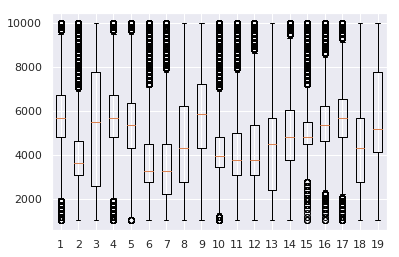

In [111]:
plt.boxplot(f_mode_t)

In [127]:
#save data of all the birds
file2 = open('total_birds_1.pckl', 'wb')
pickle.dump(dataset[:10], file2)
file2.close()

file3 = open('total_birds_2.pckl', 'wb')
pickle.dump(dataset[10:], file3)
file3.close()

In [154]:
#test: get the features of dataset[0] and save it to a csv file
f,t,Spec=signal.spectrogram(dataset[0],rate)
t,f,Spec=select_freq(t,f,Spec)
features_0=[]
l=Create_Seq(Spec)


In [179]:
#save the features and labels to a csv file
with open('features_dataset.csv', "w") as output:
    writer = csv.writer(output, quoting=csv.QUOTE_ALL)
    for i,data in enumerate(dataset):
        f,t,Spec=signal.spectrogram(data,rate)
        t,f,Spec=select_freq(t,f,Spec)
        l=Create_Seq(Spec)
        for seq in l:
            fe=features_chosen(f,seq)
            fe.append(birds_name[i])
    #print(type(fe))
            writer.writerow(fe)
        #writer.writerows(birds_name[0])


## convert to pd.dataframe QAX dead

In [137]:
import pandas as pd

In [141]:
for name in birds_name:
    file1 = open(name + '.pckl', 'wb')
    t,f,Spec=select_freq(t,f,Spec)
    features_0=

2583255.5

In [147]:
def pdFrame_bird(name):
    file1 = open(name + '.pckl', 'rb')
    data = pickle.load(file1)
    df = pd.DataFrame(data)
    return df

In [149]:
df = pdFrame_bird("Bombadil")

In [151]:
36451292/6.

6075215.333333333

# ML


## Get data

In [3]:
df = pd.read_csv("features_dataset.csv", \
                 names=['f_mod5', 'f_mod50', 'f_mod95', 'df_mod50', 'df_mod75', 'df_mod90', 'b_name'])

In [4]:
df.describe()

,f_mod5,f_mod50,f_mod95,df_mod50,df_mod75,df_mod90
count,15055.000000,15055.000000,15055.000000,15055.000000,15055.000000,15055.000000
mean,3361.473893,4766.545790,6972.438299,-13.101570,550.426146,2065.631331
std,1325.713505,1676.951200,2010.010634,77.385691,329.974859,1019.139862
min,1033.593750,1205.859375,1894.921875,-344.531250,0.000000,172.265625
25%,2411.718750,3445.312500,5512.500000,0.000000,344.531250,1378.125000
50%,3100.781250,4651.171875,7235.156250,0.000000,516.796875,1894.921875
75%,4134.375000,5684.765625,8613.281250,0.000000,689.062500,2583.984375
max,8957.812500,9819.140625,9991.406250,516.796875,3445.312500,8268.750000


In [5]:
df.head()

,f_mod5,f_mod50,f_mod95,df_mod50,df_mod75,df_mod90,b_name
0,3273.046875,5857.031250,8096.484375,-172.265625,861.328125,2583.984375,Eastern-Corn-Skeet
1,2756.250000,6029.296875,7062.890625,0.000000,516.796875,2411.718750,Eastern-Corn-Skeet
2,3789.843750,5857.031250,7062.890625,0.000000,344.531250,2583.984375,Eastern-Corn-Skeet
3,4134.375000,5512.500000,7407.421875,0.000000,516.796875,1550.390625,Eastern-Corn-Skeet
4,2583.984375,3617.578125,5512.500000,0.000000,344.531250,1378.125000,Eastern-Corn-Skeet


In [6]:
X = df.iloc[:,:6]

In [7]:
Y = df.iloc[:,[6]]

In [8]:
Y.groupby(['b_name']).size()

b_name
Bent-Beak-Riffraff             479
Blue-collared-Zipper           358
Bombadil                      1627
Broad-winged-Jojo              879
Canadian-Cootamum              567
Carries-Champagne-Pipit        307
Darkwing-Sparrow               985
Eastern-Corn-Skeet             691
Green-Tipped-Scarlet-Pipit     380
Lesser-Birchbeere             1108
Orange-Pine-Plover            2053
Ordinary-Snape                 645
Pinkfinch                      549
Purple-Tooting-Tout            599
Qax                            328
Queenscoat                    1159
Rose-Crested-Blue-Pipit       1087
Scrawny-Jay                    419
Vermillion-Trillian            835
dtype: int64

## SVM 

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.03)  

In [10]:
y_train2 = np.array(y_train).ravel()

In [12]:
y_train3 = y_train2 == 'Rose-Crested-Blue-Pipit'

In [15]:
y_train3 = y_train3.astype(int)

In [16]:
y_train3

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
X_train

In [19]:
X_train2 = preprocessing.scale(X_train)

In [38]:
# clf = svm.SVC(gamma='scale',kernel='poly', degree=8, verbose = True)  
# clf.fit(X_train, y_train2) 
clf = svm.SVC(kernel='rbf',verbose=True,cache_size=2000)
clf.fit(X_train2, y_train3)

[LibSVM]

SVC(C=1.0, cache_size=2000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=True)

In [45]:
# clf = svm.SVC(gamma='scale',kernel='poly', degree=8, verbose = True)  
# clf.fit(X_train, y_train2) 
clf2 = svm.SVC(kernel='rbf',verbose=True,cache_size=2000)
clf2.fit(X_train2, y_train2)

[LibSVM]

SVC(C=1.0, cache_size=2000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=True)

In [39]:
X_test2 = preprocessing.scale(X_test)

In [40]:
y_test2 = np.array(y_test).ravel()
y_test3 = y_test2 == 'Rose-Crested-Blue-Pipit'
y_test3 = y_test3.astype(int)

In [41]:
y_pred = clf.predict(X_test2)

In [42]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [43]:
y_test3

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [44]:
print(confusion_matrix(y_test3, y_pred))  
print(classification_report(y_test3, y_pred)) 

[[421   0]
 [ 31   0]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       421
           1       0.00      0.00      0.00        31

   micro avg       0.93      0.93      0.93       452
   macro avg       0.47      0.50      0.48       452
weighted avg       0.87      0.93      0.90       452



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [48]:
y_pred2 = clf2.predict(X_test2)

In [49]:
y_pred2

array(['Rose-Crested-Blue-Pipit', 'Orange-Pine-Plover',
       'Green-Tipped-Scarlet-Pipit', 'Rose-Crested-Blue-Pipit',
       'Bombadil', 'Eastern-Corn-Skeet', 'Orange-Pine-Plover',
       'Lesser-Birchbeere', 'Lesser-Birchbeere', 'Broad-winged-Jojo',
       'Lesser-Birchbeere', 'Bombadil', 'Rose-Crested-Blue-Pipit',
       'Green-Tipped-Scarlet-Pipit', 'Bombadil', 'Broad-winged-Jojo',
       'Queenscoat', 'Broad-winged-Jojo', 'Darkwing-Sparrow',
       'Darkwing-Sparrow', 'Orange-Pine-Plover', 'Pinkfinch',
       'Green-Tipped-Scarlet-Pipit', 'Lesser-Birchbeere', 'Queenscoat',
       'Orange-Pine-Plover', 'Orange-Pine-Plover', 'Eastern-Corn-Skeet',
       'Orange-Pine-Plover', 'Lesser-Birchbeere', 'Darkwing-Sparrow',
       'Orange-Pine-Plover', 'Lesser-Birchbeere',
       'Rose-Crested-Blue-Pipit', 'Orange-Pine-Plover',
       'Lesser-Birchbeere', 'Orange-Pine-Plover', 'Broad-winged-Jojo',
       'Rose-Crested-Blue-Pipit', 'Orange-Pine-Plover', 'Queenscoat',
       'Rose-Crested-Blu

In [50]:
print(confusion_matrix(y_test2, y_pred2))  
print(classification_report(y_test2, y_pred2)) 

[[ 2  0  4  1  0  0  0  2  1  0  3  0  0  0  0  4  1  0  0]
 [ 0  0  1  0  0  0  0  0  0  2  2  0  0  0  0  1  0  0  0]
 [ 0  0 33  4  0  0  0  2  0  1  3  1  1  0  0  2  3  0  0]
 [ 1  0  7 10  0  0  0  0  0  0  5  0  0  0  0  0  3  1  0]
 [ 0  0  0  2  1  0  1  1  1  1  1  0  0  0  0  4  1  0  0]
 [ 0  0  1  0  0  0  4  0  0  1  1  0  0  0  0  1  2  0  0]
 [ 1  0  5  1  0  0 21  1  1  1  0  0  0  0  0  2  0  0  0]
 [ 0  0  4  1  0  0  1  5  0  3  3  2  0  0  0  3  2  0  0]
 [ 0  0  0  0  0  0  1  0 13  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  3  0  0  0  0  4  3 15  3  0  1  0  0  2  2  0  0]
 [ 1  0  4  4  0  0  1  0  0  0 34  0  0  0  0  7  8  2  0]
 [ 0  0  0  0  0  0  5  1  0  2  3  0  0  0  0  0  2  0  0]
 [ 0  0  1  0  0  0  0  0  0  0 13  0  2  0  0  1  3  0  0]
 [ 1  0  1  1  0  0  0  0  2  1  8  0  0  0  0  3  3  0  0]
 [ 0  0  2  2  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  0  0  7  9  0  0  0  0 16  7  0  0]
 [ 0  0  1  0  0  0  3  0  0  4  5  0  0

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
